# Capstone Project

## Modelling with BERT

In [1]:
#importing Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import Adam


## Loading the data

In [2]:
df = pd.read_csv('WELFake_Dataset.csv')
df

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
...,...,...,...,...
72129,72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


## Data pre-processing

In [3]:
#Dropping "Unnamed: 0" column
 
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [5]:
#check for null values
df.isnull().sum()

title    558
text      39
label      0
dtype: int64

In [6]:
# Drop rows with null values
df.dropna(subset=['title', 'text'], inplace=True)

In [7]:
# Combine 'title' and 'text' columns
df['content'] = df['title'] + " " + df['text']

In [8]:
# Split data into training and test sets

## Split the Data

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

## Tokenization with BERT Tokenizer


In [10]:
# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenization function
def encode_examples(df, max_length=128):
    input_ids = []
    attention_masks = []
    labels = []
    
    for _, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(
            row['content'],                     # Text to encode
            add_special_tokens=True,            # Add '[CLS]' and '[SEP]'
            max_length=max_length,              # Pad & truncate to max length
            padding='max_length',
            truncation=True,
            return_attention_mask=True,         # Construct attention masks
            return_tensors='tf',                # Return TensorFlow tensors
        )
        
        # Add the encoded inputs to lists
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(row['label'])
    
    # Convert lists to tensors
    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)
    labels = tf.convert_to_tensor(labels)
    
    return input_ids, attention_masks, labels

# Encode training and test sets
train_input_ids, train_attention_masks, train_labels = encode_examples(train_df)
test_input_ids, test_attention_masks, test_labels = encode_examples(test_df)


## Train the model

In [12]:
# Load DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)  # Recommended learning rate for BERT
model.compile(optimizer=optimizer, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Train the model
history = model.fit(
    [train_input_ids, train_attention_masks], train_labels,
    validation_data=([test_input_ids, test_attention_masks], test_labels),
    epochs=2,  # Adjust based on dataset size and performance
    batch_size=16  # Adjust based on available memory
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
3577/3577 [==============================] - 5746s 2s/step - loss: 0.0496 - accuracy: 0.9815 - val_loss: 0.0261 - val_accuracy: 0.9901
Epoch 2/2
3577/3577 [==============================] - 5750s 2s/step - loss: 0.0141 - accuracy: 0.9949 - val_loss: 0.0226 - val_accuracy: 0.9924


## Evaluation

In [13]:
## # Predict on the test set
test_predictions = model.predict([test_input_ids, test_attention_masks])
predicted_labels = tf.argmax(test_predictions.logits, axis=1).numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
f1 = f1_score(test_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")



448/448 [==============================] - 433s 964ms/step
Accuracy: 0.9923818842605535
Precision: 0.9930728733721252
Recall: 0.9918361699183617
F1 Score: 0.9924541363793701


448/448 [==============================] - 436s 973ms/step


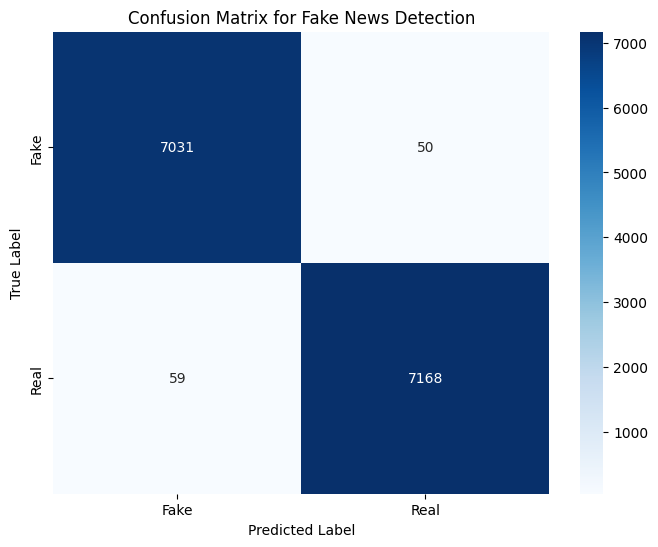

In [15]:
# Step 1: Make Predictions on the Test Set
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

test_predictions = model.predict([test_input_ids, test_attention_masks])
predicted_labels = np.argmax(test_predictions.logits, axis=1)

# Step 2: Generate the Confusion Matrix
cm = confusion_matrix(test_labels, predicted_labels)
labels = ['Fake', 'Real']  # Customize as needed for your dataset

# Step 3: Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fake News Detection')
plt.show()

## Save the model

In [16]:
model.save_pretrained("bert_model")
tokenizer.save_pretrained("bert_tokenizer")

('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json')

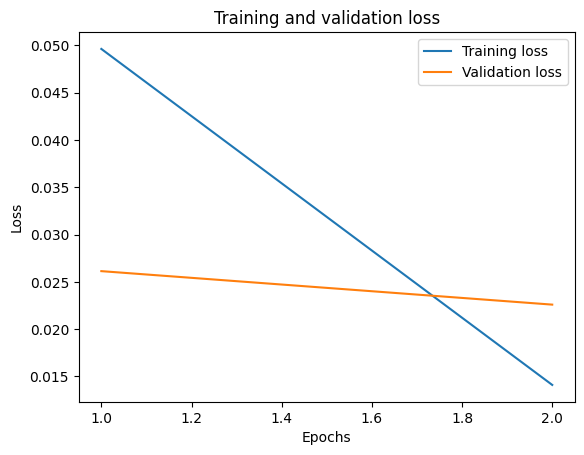

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();